<a href="https://colab.research.google.com/github/Nukitt/AQASH/blob/main/AQASH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

!pip install datasets transformers
import transformers

In [2]:

model_checkpoint = 'deepset/xlm-roberta-base-squad2'
batch_size = 4


In [3]:
from transformers import AutoTokenizer
!pip install sentencepiece    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

     |████████████████████████████████| 1.2 MB 5.2 MB/s 


Downloading:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [4]:
train = pd.read_csv('dataset/train.csv')
train['num_tokens_context'] = train['context'].apply(lambda t: len(tokenizer(t)['input_ids']))

Token indices sequence length is longer than the specified maximum sequence length for this model (676 > 512). Running this sequence through the model will result in indexing errors


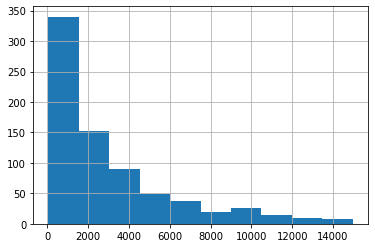

In [5]:
train['num_tokens_context'].hist()

In [6]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [7]:
pad_on_right = tokenizer.padding_side == "right"

In [8]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
!pip install Dataset
!pip uninstall fsspec -qq -y
!pip install --no-index --find-links hf-datasets/wheels datasets -qq
!pip install fsspec

In [10]:
from datasets import Dataset

In [11]:
def convert_answers(r):
    start = r[0]
    text = r[1]
    return {
        'answer_start': [start],
        'text': [text]
    }

In [12]:
train = train.sample(frac=1, random_state=42)
train['answers'] = train[['answer_start', 'answer_text']].apply(convert_answers, axis=1)

In [13]:
df_train = train[:-64].reset_index(drop=True)
df_valid = train[-64:].reset_index(drop=True)

In [14]:
train_dataset = Dataset.from_pandas(df_train)
valid_dataset = Dataset.from_pandas(df_valid)

In [15]:
train_dataset[0]

{'answer_start': 14,
 'answer_text': 'दुबई',
 'answers': {'answer_start': [14], 'text': ['दुबई']},
 'context': 'बुर्ज ख़लीफ़ा दुबई में आठ अरब डॉलर की लागत से छह साल में निर्मित ८२८ मीटर ऊँची १६८ मंज़िला दुनिया की सबसे ऊँची इमारत है (जनवरी, सन् २०१० में)। इसका लोकार्पण ४ जनवरी, २०१० को भव्य उद्घाटन समारोह के साथ किया गया। इसमें तैराकी का स्थान, खरीदारी की व्यवस्था, दफ़्तर, सिनेमा घर सहित सारी सुविधाएँ मौजूद हैं। इसकी ७६ वीं मंजिल पर एक मस्जिद भी बनायी गयी है। इसे ९६ किलोमीटर दूर से भी साफ़-साफ़ देखा जा सकता है। इसमें लगायी गयी लिफ़्ट दुनिया की सबसे तेज़ चलने वाली लिफ़्ट है। “ऐट द टॉप” नामक एक दरवाज़े के बाहर अवलोकन डेक, 124 वीं मंजिल पर, 5 जनवरी 2010 पर खुला। यह 452 मीटर (1,483 फुट) पर, दुनिया में तीसरे सर्वोच्च अवलोकन डेक और दुनिया में दूसरा सबसे बड़ा दरवाज़े के बाहर अवलोकन डेक है।\r\nनिर्माण विशेषता सन्दर्भ\r\nबाहरी\xa0कड़ियाँ\r\nNo URL found. Please specify a URL here or add one to Wikidata.\r\nश्रेणी: गगनचुम्बी इमारतें\r\nश्रेणी: सर्वोच्च गगनचुम्बी',
 'id': 'b5ef4590a',
 'language':

In [16]:
tokenized_train_ds = train_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)
tokenized_valid_ds = valid_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [17]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

In [18]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


In [19]:
args = TrainingArguments(
    f"chaii-qa",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    warmup_ratio=0.1,
    gradient_accumulation_steps=8,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [20]:
from transformers import default_data_collator

data_collator = default_data_collator

In [21]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_valid_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

In [25]:
trainer.save_model("bert-trained")

Saving model checkpoint to bert-trained
Configuration saved in bert-trained/config.json
Model weights saved in bert-trained/pytorch_model.bin
tokenizer config file saved in bert-trained/tokenizer_config.json
Special tokens file saved in bert-trained/special_tokens_map.json


In [26]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [27]:
validation_features = valid_dataset.map(
    prepare_validation_features,
    batched=True,
    remove_columns=valid_dataset.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [28]:
len(validation_features)

843

In [29]:
validation_features

Dataset({
    features: ['attention_mask', 'example_id', 'input_ids', 'offset_mapping'],
    num_rows: 843
})

In [30]:
valid_feats_small = validation_features.map(lambda example: example, remove_columns=['example_id', 'offset_mapping'])
valid_feats_small

  0%|          | 0/843 [00:00<?, ?ex/s]

Dataset({
    features: ['attention_mask', 'input_ids'],
    num_rows: 843
})

In [31]:
raw_predictions = trainer.predict(valid_feats_small)

***** Running Prediction *****
  Num examples = 843
  Batch size = 4


Epoch,Training Loss,Validation Loss


In [32]:
max_answer_length = 30

In [33]:
import collections

examples = valid_dataset
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [34]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        predictions[example["id"]] = best_answer["text"]

    return predictions

In [35]:
final_predictions = postprocess_qa_predictions(valid_dataset, validation_features, raw_predictions.predictions)

Post-processing 64 example predictions split into 843 features.


  0%|          | 0/64 [00:00<?, ?it/s]

In [36]:
references = [{"id": ex["id"], "answer": ex["answers"]['text'][0]} for ex in valid_dataset]

In [37]:
def jaccard(row): 
    str1 = row[0]
    str2 = row[1]
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [38]:
res = pd.DataFrame(references)
res['prediction'] = res['id'].apply(lambda r: final_predictions[r])
res['jaccard'] = res[['answer', 'prediction']].apply(jaccard, axis=1)
res

,id,answer,prediction,jaccard
0,151071dab,‘आर्थोपोडा,आर्थोपोडा,0.000000
1,4a92c37c2,1613 ई.,1613,0.500000
2,c20772e17,1927,1927,1.000000
3,455f23be7,एस एन डी टी,एस एन डी टी महिला विश्वविघालय,0.666667
4,eddadac58,स्वामी हरिदास,स्वामी हरिदास जी,0.666667
...,...,...,...,...
59,58b3676a4,मराठी,मराठी,1.000000
60,5aeacd81a,सेंट्रल प्रोसेसिंग यूनिट,एक सेंट्रल प्रोसेसिंग यूनिट,0.750000
61,89d938493,इब्न-अल-हज़ैन,इब्न-अल-हज़ैन,1.000000
62,8d13dfd40,फ़्रांसिसी,रने डॅकार्ट (फ़्रांसिसी भाषा: René Descartes,0.000000


In [39]:
res.jaccard.mean()

0.58125

In [40]:
test = pd.read_csv('dataset/test.csv')

In [41]:
test_dataset = Dataset.from_pandas(test)

In [42]:
test_features = test_dataset.map(
    prepare_validation_features,
    batched=True,
    remove_columns=test_dataset.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [43]:
test_feats_small = test_features.map(lambda example: example, remove_columns=['example_id', 'offset_mapping'])
test_feats_small

  0%|          | 0/51 [00:00<?, ?ex/s]

Dataset({
    features: ['attention_mask', 'input_ids'],
    num_rows: 51
})

In [44]:
test_predictions = trainer.predict(test_feats_small)

***** Running Prediction *****
  Num examples = 51
  Batch size = 4


Epoch,Training Loss,Validation Loss


In [45]:
test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))

In [46]:
final_test_predictions = postprocess_qa_predictions(test_dataset, test_features, test_predictions.predictions)

Post-processing 3 example predictions split into 51 features.


  0%|          | 0/3 [00:00<?, ?it/s]

In [47]:
sub = pd.read_csv('dataset/sample_submission.csv')

In [48]:
sub['PredictionString'] = sub['id'].apply(lambda r: final_test_predictions[r])
sub.head()

,id,PredictionString
0,22bff3dec,येलन चीन
1,282758170,जून 2005
2,d60987e0e,१७ अक्टूबर १८८७


In [49]:
sub.to_csv('submission.csv', index=False)